In [1]:
# %load ../jupyter_setup.txt
# Convenient jupyter setup
%load_ext autoreload
%load_ext line_profiler
%autoreload 2
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False 

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import pandas as pd

import rioxarray as rxr
import geopandas as gpd

import pylandstats as pls
from src.plot_settings import (
    ps_defaults,
    label_subplots,
    get_dim,
    set_dim,
    PALETTE,
    STD_CLR_LIST,
    CAM_BLUE,
    BRICK_RED,
    OX_BLUE,
)

ps_defaults(use_tex=True)

from src.geograph import GeoGraph
from src.geograph.geotimeline import TimedGeoGraph, GeoGraphTimeline
from src.geograph.binary_graph_operations import NodeMap, identify_graphs, graph_polygon_diff, node_polygon_diff
from src.constants import GWS_DATA_DIR, ESA_LANDCOVER_DIR, UTM35N

# Parse geotif landcover data
chernobyl_path = lambda year: GWS_DATA_DIR / "esa_cci_rois" / f"esa_cci_{year}_chernobyl.tif" 

# Parse ROIS
rois = gpd.read_file(GWS_DATA_DIR / "chernobyl_exclusion_zone_v1.geojson")
cez = rois[rois["name"] == "Chernobyl Exclusion Zone"]
ez = rois[rois.name.str.contains("Exclusion")]

/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## 2. Load Chernobyl Exclusion Zone data

In [3]:
def clip_and_reproject(xrdata, clip_geometry=None, to_crs=UTM35N, x_res=300, y_res=300):
    
    if clip_geometry is not None:
        clipped_data = xrdata.rio.clip(clip_geometry)
    else:
        clipped_data = xrdata
        
    if to_crs is not None:
        reprojected_data = clipped_data.rio.reproject(to_crs, resolution=(x_res, y_res))
    else:
        reprojected_data = clipped_data
    
    return reprojected_data

In [5]:
# Demo path includes pre-loaded graphs for faster loading
demo_path = GWS_DATA_DIR / "geograph_timeline_demo"

In [7]:
# Loading geographs
years = list(range(2000,2015))
cez_graphs = {year: GeoGraph(demo_path / f"cez_graph_{year}.gz")
              for year in years}

Graph successfully loaded with 1924 nodes and 4912 edges.
Graph successfully loaded with 1931 nodes and 4918 edges.
Graph successfully loaded with 1929 nodes and 4897 edges.
Graph successfully loaded with 1936 nodes and 4911 edges.
Graph successfully loaded with 1953 nodes and 4953 edges.
Graph successfully loaded with 1960 nodes and 4973 edges.
Graph successfully loaded with 2004 nodes and 5113 edges.
Graph successfully loaded with 1996 nodes and 5141 edges.
Graph successfully loaded with 1992 nodes and 5119 edges.
Graph successfully loaded with 1994 nodes and 5108 edges.
Graph successfully loaded with 1988 nodes and 5080 edges.
Graph successfully loaded with 2003 nodes and 5131 edges.
Graph successfully loaded with 1998 nodes and 5119 edges.
Graph successfully loaded with 2003 nodes and 5140 edges.
Graph successfully loaded with 1999 nodes and 5117 edges.


In [8]:
for graph in cez_graphs.values():
    no_data_nodes = graph.df[graph.df["class_label"] == 0].index
    graph._remove_nodes(no_data_nodes)

In [9]:
cez_timeline = GeoGraphTimeline(cez_graphs)

In [10]:
# Perform node identification between adjacent time slices
cez_timeline.timestack()

# 3. Plots

Let us now visualise the ecosystem dynamics from 2013 to 2014

In [18]:
# Identify node dynamics for the year 2014
cez_timeline.calculate_node_dynamics(2014)

node_index
0       unchanged
1       unchanged
2       unchanged
3       unchanged
4       unchanged
          ...    
1995    unchanged
1996    unchanged
1997    unchanged
1998    unchanged
1999    unchanged
Name: node_dynamic, Length: 1999, dtype: object

In [19]:
cez_timeline[2014].df.node_dynamic.unique()

array(['unchanged', 'split', 'birth', 'grew', 'shrank', 'complex',
       'merged'], dtype=object)

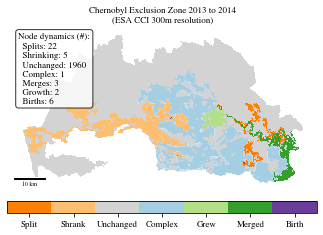

In [37]:
graph = cez_timeline[2014]

plot_scale_factor=1
dynamic_to_int = {'split': 0, 
                  'shrank': 1,
                  'unchanged': 2,
                  'complex': 3,
                  'grew': 4,
                  'merged': 5,
                  'birth': 6}

colors = sns.color_palette("Paired").as_hex()
dynamic = lambda x: dynamic_to_int[x]
graph.df["dynamic_class"] = graph.df.node_dynamic.map(dynamic)

fig, ax = plt.subplots(1)
plt.title("Chernobyl Exclusion Zone 2013 to 2014\n(ESA CCI 300m resolution)", fontsize=9*plot_scale_factor)
set_dim(fig, fraction_of_line_width=plot_scale_factor)
vmin, vmax = 0, 7
cmap = mpl.colors.ListedColormap([colors[7], colors[6], 'lightgrey', colors[0], colors[2], colors[3], colors[9]])
graph.df.plot(column='dynamic_class', cmap=cmap, vmin=vmin, vmax=vmax, ax=ax)
ax.set_xticks([])
ax.set_yticks([])

inset_text = ("Node dynamics (#):\n"
              f"  Splits: {np.sum(graph.df['node_dynamic'] == 'split')}\n"
              f"  Shrinking: {np.sum(graph.df['node_dynamic'] == 'shrank')}\n"
              f"  Unchanged: {np.sum(graph.df['node_dynamic'] == 'unchanged')}\n"
              f"  Complex: {np.sum(graph.df['node_dynamic'] == 'complex')}\n"
              f"  Merges: {np.sum(graph.df['node_dynamic'] == 'merged')}\n"
              f"  Growth: {np.sum(graph.df['node_dynamic'] == 'grew')}\n"
              f"  Births: {np.sum(graph.df['node_dynamic'] == 'birth')}"
             )

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

# place a text box in upper left in axes coords
ax.text(0.03, 0.97, inset_text, transform=ax.transAxes, fontsize=9*plot_scale_factor,
        verticalalignment='top', bbox=props)

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=6*plot_scale_factor)
scalebar = AnchoredSizeBar(ax.transData,
                           1e4, '10 km', 'lower left', 
                           pad=0,
                           borderpad=.8,
                           color='black',
                           frameon=False,
                           size_vertical=250,
                           fontproperties=fontprops
                       )

ax.add_artist(scalebar)

# add colorbar
fig = ax.get_figure()
cax = fig.add_axes([0.12, 0.08, 0.78, 0.05]) # left-offset, # bottom offset # width, # height
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, cax=cax, orientation="horizontal")
cbar.set_ticks(np.arange(vmin+0.5, vmax+1))
cbar.set_ticklabels(["Split", "Shrank", "Unchanged", "Complex", "Grew", "Merged", "Birth"])
cbar.ax.tick_params(labelsize=9*plot_scale_factor) 
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)



#plt.savefig("CEZ_node_dynamics.svg")
#plt.savefig("CEZ_node_dynamics.png")

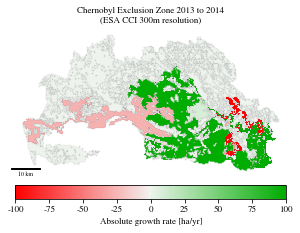

In [38]:
plot_scale_factor=1
fig, ax = plt.subplots(1)
set_dim(fig, fraction_of_line_width=plot_scale_factor)

cmap = sns.diverging_palette(6, 120, s=360, l=55, as_cmap=True)
norm = mpl.colors.TwoSlopeNorm(vcenter=0, vmin=-10e5, vmax=10e5)

graph.df.plot("absolute_growth", ax=ax, cmap=cmap, norm=norm, edgecolor="grey", linewidth=0.1)
ax.set_xticks([])
ax.set_yticks([])
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=6*plot_scale_factor)
scalebar = AnchoredSizeBar(ax.transData,
                           1e4, '10 km', 'lower left', 
                           pad=0,
                           borderpad=.3,
                           color='black',
                           frameon=False,
                           size_vertical=250,
                           fontproperties=fontprops
                       )

ax.add_artist(scalebar)

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
             orientation='horizontal', 
             label='Absolute growth rate [ha / yr]',
             #aspect=9,
             shrink=0.88,
             pad=0.04
            )
cbar.set_ticks([-10e5, -7.5*1e5, -5e5, -2.5*1e5, 0, 2.5*1e5, 5e5, 7.5*1e5, 10e5])
cbar.set_ticklabels([-100, -75, -50, -25, 0, 25, 50, 75, 100])
cbar.ax.tick_params(labelsize=9*plot_scale_factor) 
cbar.set_label("Absolute growth rate [ha/yr]", fontsize=9*plot_scale_factor)
plt.title("Chernobyl Exclusion Zone 2013 to 2014\n(ESA CCI 300m resolution)", fontsize=9*plot_scale_factor)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig("CEZ_node_growth_rates.svg")
plt.savefig("CEZ_node_growth_rates.pdf")
plt.savefig("CEZ_node_growth_rates.png")

In [16]:
cez_timeline[2014].get_patch_metrics()

,class_label,area,perimeter,perimeter_area_ratio,shape_index,fractal_dimension
node_index,,,,,,
0,100,270000.0,2400.0,0.008889,1.154701,1.023003
1,70,90000.0,1200.0,0.013333,1.000000,1.000000
2,130,180000.0,1800.0,0.010000,1.060660,1.009734
3,30,90000.0,1200.0,0.013333,1.000000,1.000000
4,30,90000.0,1200.0,0.013333,1.000000,1.000000
...,...,...,...,...,...,...
1995,30,810000.0,6600.0,0.008148,1.833333,1.089106
1996,60,180000.0,2400.0,0.013333,1.414214,1.057282
1997,100,180000.0,2400.0,0.013333,1.414214,1.057282


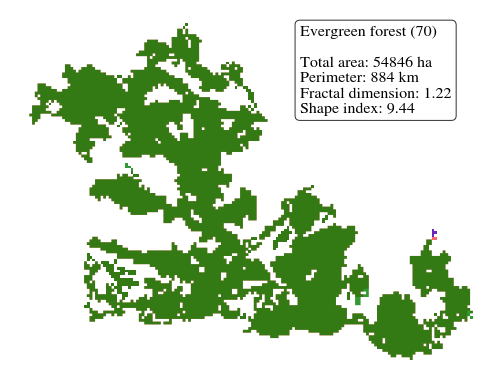

In [39]:
fig, ax = plt.subplots(1)
plot_scale_factor=2
set_dim(fig, fraction_of_line_width=plot_scale_factor)

cez_timeline[2013].df.loc[1629:1629].plot(ax=ax, color="red", alpha=0.6)
cez_timeline[2014].df.loc[1187:1187].plot(ax=ax, color="blue", alpha=0.6)
cez_timeline[2014].df.loc[1625:1625].plot(ax=ax, color="green", alpha=0.8)

inset_text = (
              f"Evergreen forest (70)\n\n"
              f"Total area: {graph.df.area.loc[1625]/1e4:.0f} ha\n"
              f"Perimeter: {graph.df.perimeter.loc[1625]/1e3:.0f} km\n"
              f"Fractal dimension: {graph.df.fractal_dimension.loc[1625]:.2f}\n"
              f"Shape index: {graph.df.shape_index.loc[1625]:.2f}"
             
             )

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

# place a text box in upper left in axes coords
ax.text(0.6, 0.95, inset_text, transform=ax.transAxes, fontsize=8*plot_scale_factor,
        verticalalignment='top', bbox=props)

ax.set_xticks([])
ax.set_yticks([])
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.savefig("CEZ-nodediff-example.svg")
plt.savefig("CEZ-nodediff-example.pdf")